In [1]:
from cil.io import ZEISSDataReader
from cil.framework import AcquisitionData
from cil.recon import FDK
from cil.utilities.display import show2D
from cil.utilities import dataexample
import numpy as np

In [2]:
#reading in and preparing the data for the notebook
def read_and_prepare_data(dataset="walnut"):
    if dataset == "walnut":
        path = "/mnt/share/notebooks/valnut/valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm"
        data = ZEISSDataReader(file_name=path).read()
        data.reorder("TIGRE")
        data.log(out=data)
        data *= -1
        return data
    
    elif dataset == "spheres":
        data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
        data.reorder("TIGRE")
        data.log(out=data)
        data *= -1
        return data
    
    else:
        raise ValueError("Dataset not recognized. Choose 'walnut' or 'spheres'.")


## Cone-beam geometry issues

This notebook will step through some common errors when setting up your cone-beam geometry and what the reconstruction might look like.

These could look very different for different datasets so try it on some others to compare. You should always know what you expect your reconstuction to look like - don't just trust the output blindly.

This notebook is about setting up your geometry to match your physical scanner.

In [3]:
# select the dataset to run the notebook on
# We recommend using the walnut data as this is a real dataset and has more realistic artifacts

# "walnut" or "spheres"
data_orig = read_and_prepare_data("walnut")

print("Data shape: ", data_orig.array.shape)
geometry_correct = data_orig.geometry.copy()
centre_slice = data_orig.shape[-1] // 2

Data shape:  (1601, 1024, 1024)


#### This is what we like to see!

Everything is well aligned, edges are sharp. We don't see any doubling. And it looks like a walnut!

We do see a circle around the object. This isn't a problem with the geometry. It's due to the background not quite being zero, so we see an image of the edge of the detector. This is often masked out in CT. Inside the circle is what we care about.

In [4]:
# create our AcquisitionData object with the correct geometry
data_correct = AcquisitionData(data_orig, deep_copy=False, geometry=geometry_correct)

# set up and run the FDK algorithm from CIL with the tigre backend
fdk = FDK(data_correct)
recon_good = fdk.run(verbose=0)

# visualise the results
show2D(recon_good, slice_list=[('vertical',centre_slice),('horizontal_x',centre_slice)])


Mask the circle out (if you want to)

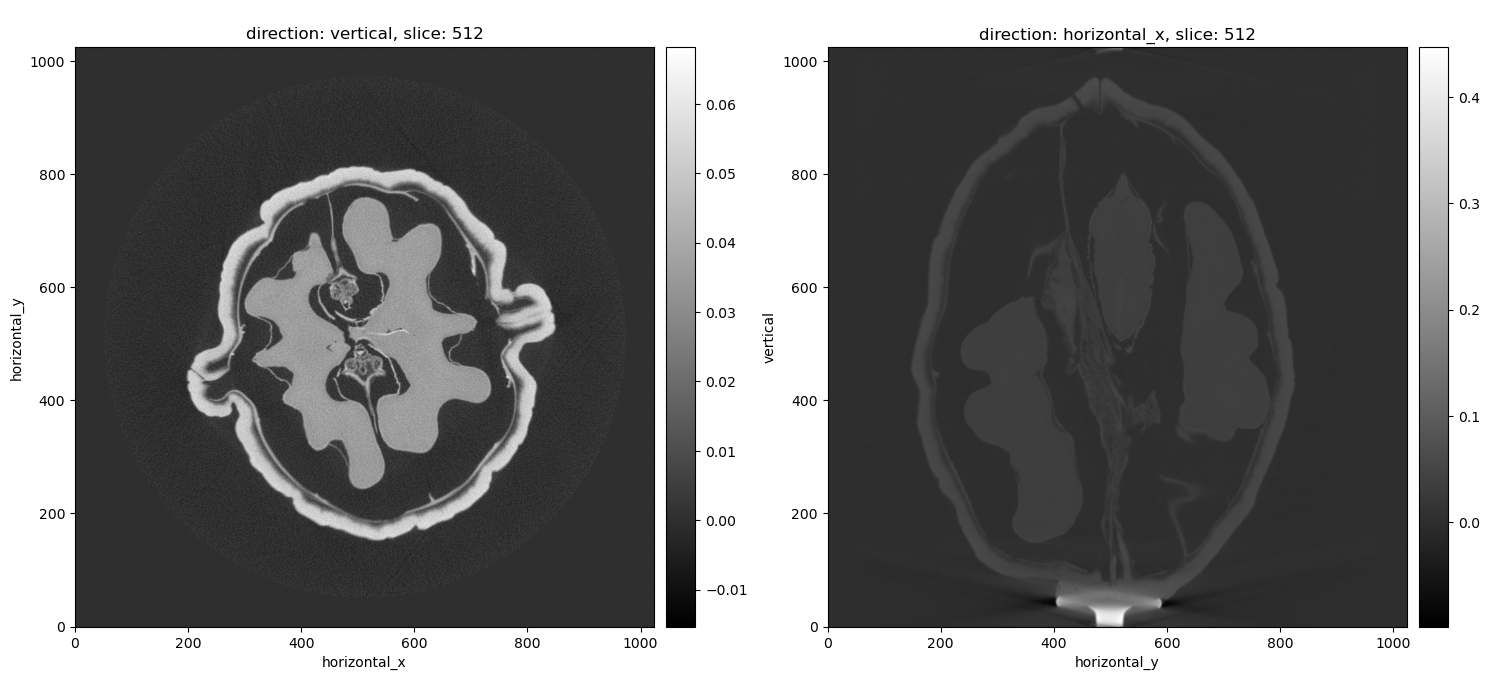

In [5]:
# apply a circular mask to the reconstruction
# this is not needed for the simulated data but is useful for the walnut data
# the mask is applied to the data in place
recon_masked = recon_good.copy()
recon_masked.apply_circular_mask(0.9)
show2D(recon_masked, slice_list=[('vertical',centre_slice),('horizontal_x',centre_slice)])

## Centre of rotation
This is a geometry issue as the reconstruction expects the sample to rotate around the every centre of the detector. If you have an offset it will look like a doubling of edges of your sample. A centre of rotation offset can make it harder to set up the rest of your geometry, but if you can set up the rest correctly, you can use CIL's processors to find the accurate centre position.

In [6]:
broken_geometry = geometry_correct.copy()

# set the centre of rotation to to 0.8 of a pixel off the centre
# this is a common error in real data
broken_geometry.set_centre_of_rotation(offset=1.2, distance_units='pixels')

# create our AcquisitionData object with the broken geometry
data_broken = AcquisitionData(data_orig, deep_copy=False, geometry=broken_geometry)

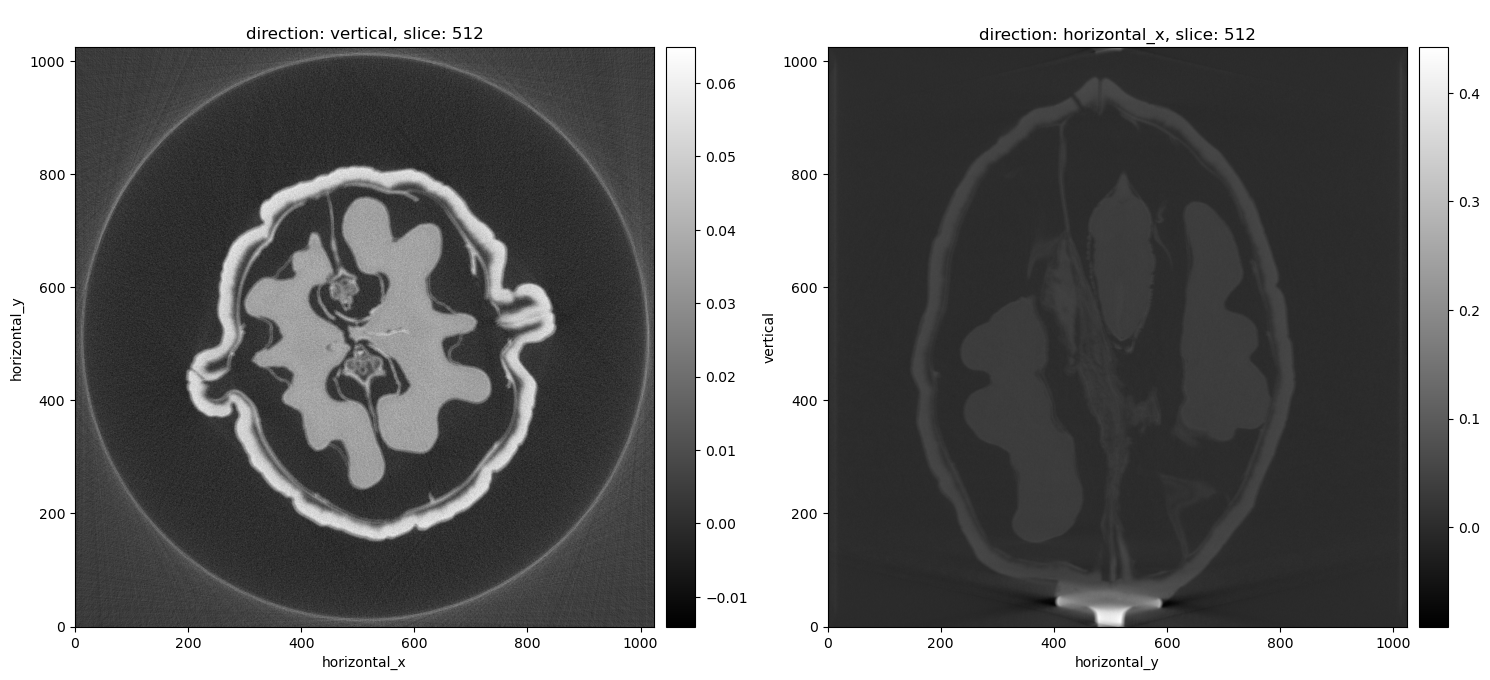

In [7]:
# set up and run the FDK algorithm from CIL with the tigre backend
fdk = FDK(data_broken)
recon =fdk.run(verbose=0)

# visualise the results
show2D(recon, slice_list=[('vertical',centre_slice),('horizontal_x',centre_slice)])

#### 

#### Angles Flipped 

For Cone beam the rotation direction matters and it's very easy to get wrong. Try adding a minus to all your angles.

In [8]:
# create a broken geometry by flipping the angles
broken_geometry = geometry_correct.copy()
angles_flipped = -data_orig.geometry.angles
broken_geometry.set_angles(angles_flipped,angle_unit="radian")

# create our AcquisitionData object with the broken geometry
data_broken = AcquisitionData(data_orig, deep_copy=False, geometry=broken_geometry)

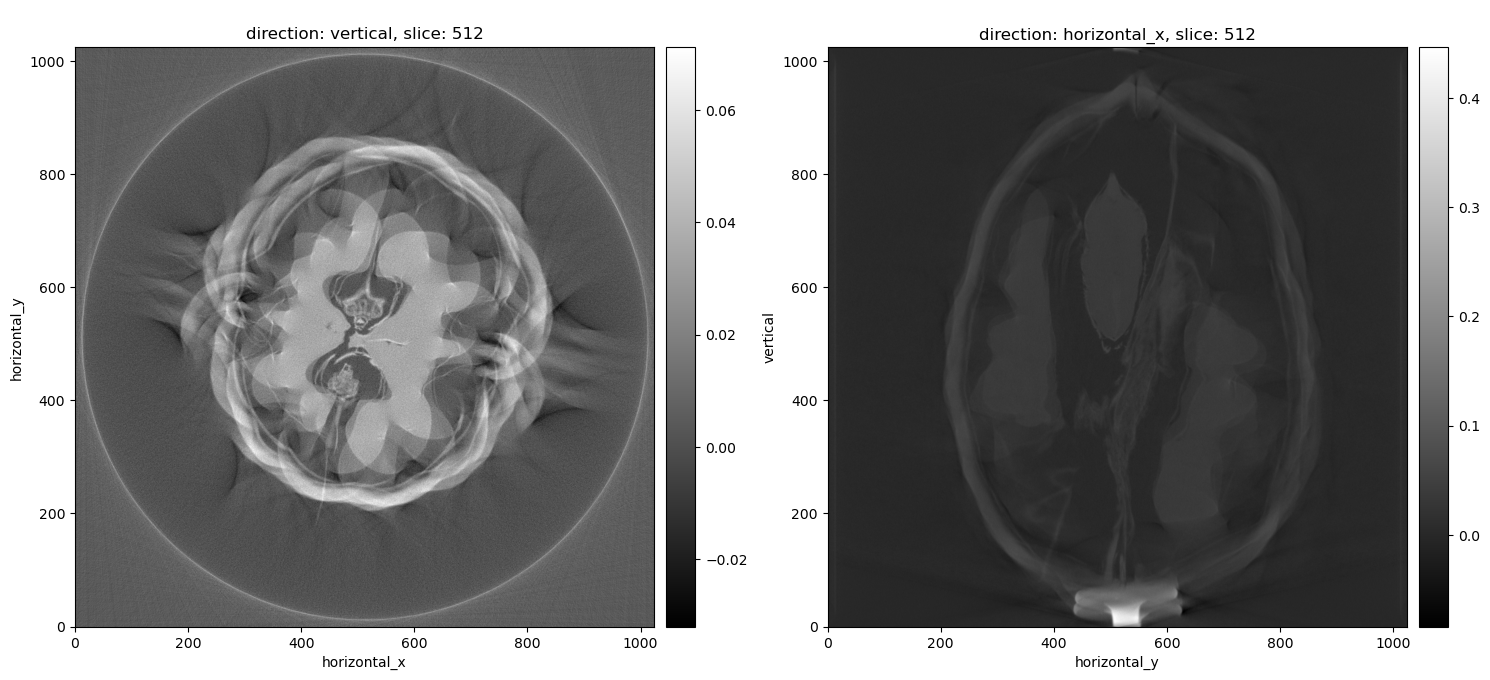

In [9]:
# set up and run the FDK algorithm from CIL with the tigre backend
fdk = FDK(data_broken)
recon =fdk.run(verbose=0)

# visualise the results
show2D(recon, slice_list=[('vertical',centre_slice),('horizontal_x',centre_slice)])

#### Angles in the wrong units

Your list of angles need to describe your data. If your angles are in radians but you tell CIL they are in degrees, or if your angles are in degrees and you specify radians.


In [10]:
# get the dataset angles in degrees and radians
# this is needed to create the broken geometry
if data_orig.geometry.config.angles.angle_unit == "degree":
    angles_degree = data_orig.geometry.angles
    angles_radian = data_orig.geometry.angles * np.pi/180
else:
    angles_degree = data_orig.geometry.angles * 180/np.pi
    angles_radian = data_orig.geometry.angles

##### Real angles in degree, specify radians

In [11]:
# create a broken geometry by setting the angles and the angle units to the wrong values
broken_geometry = geometry_correct.copy()
broken_geometry.set_angles(angles_degree,angle_unit="radian")

# create our AcquisitionData object with the broken geometry
data_broken = AcquisitionData(data_orig, deep_copy=False, geometry=broken_geometry)


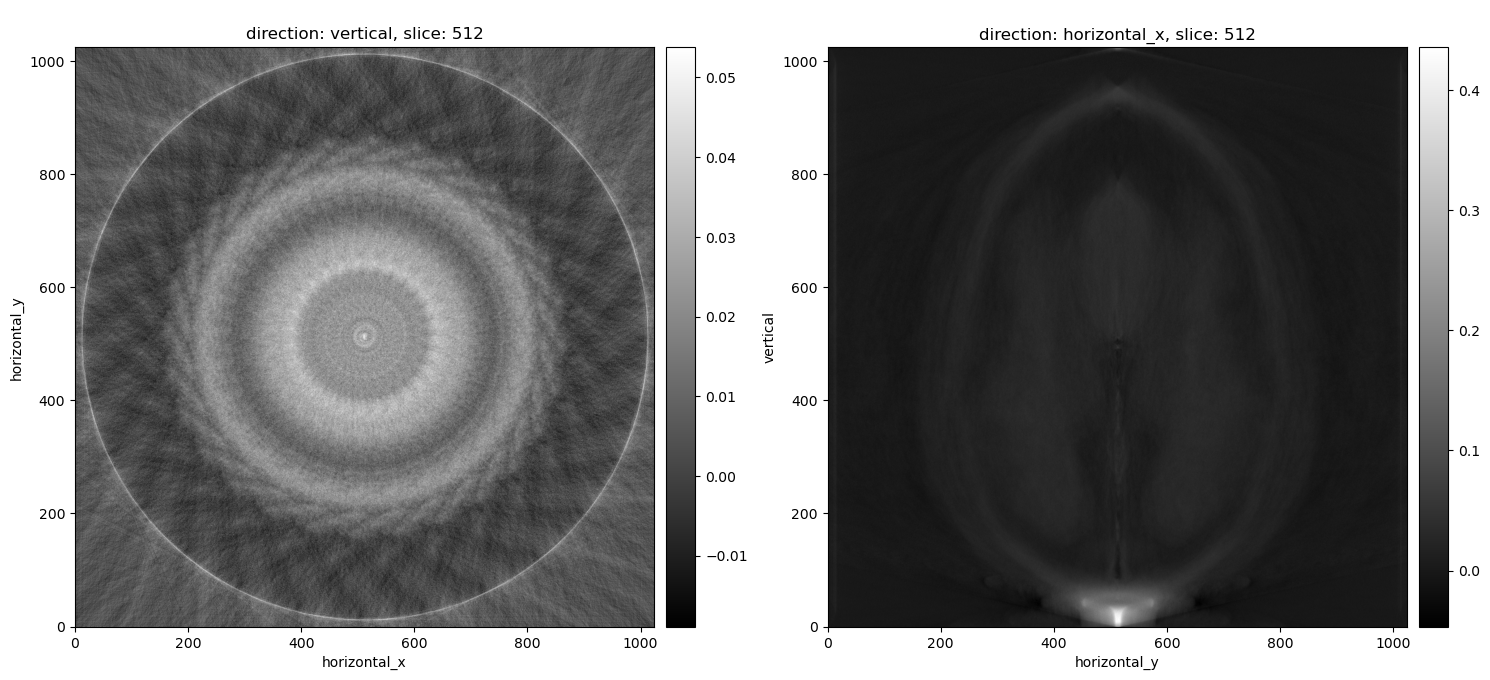

In [12]:
# set up and run the FDK algorithm from CIL with the tigre backend
fdk = FDK(data_broken)
recon = fdk.run(verbose=0)

# visualise the results
show2D(recon, slice_list=[('vertical',centre_slice),('horizontal_x',centre_slice)])

##### Real angles in radians, specify degree


In [13]:
# create a broken geometry by setting the angles and the angle units to the wrong values
broken_geometry = geometry_correct.copy()
broken_geometry.set_angles(angles_radian,angle_unit="degree")

# create our AcquisitionData object with the broken geometry
data_broken = AcquisitionData(data_orig, deep_copy=False, geometry=broken_geometry)

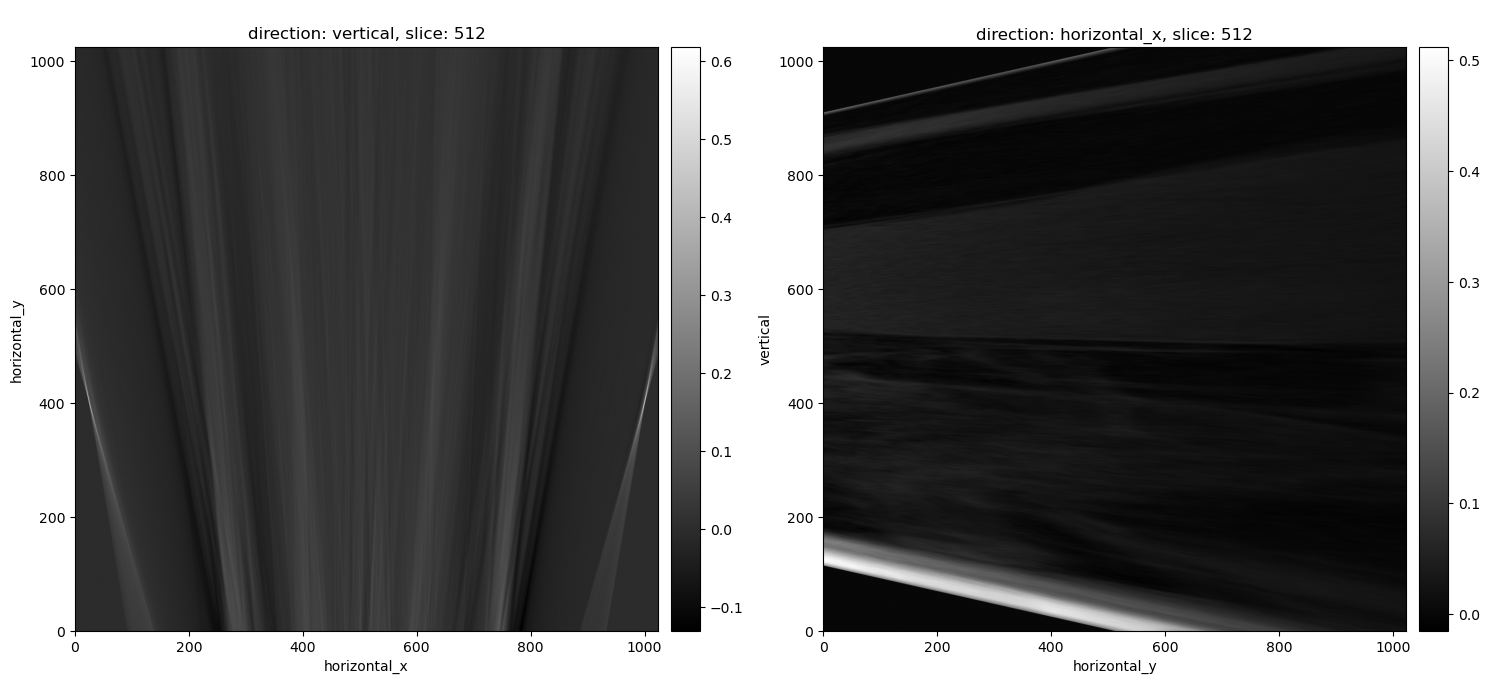

In [14]:
# set up and run the FDK algorithm from CIL with the tigre backend
fdk = FDK(data_broken)
recon = fdk.run(verbose=0)

# visualise the results
show2D(recon, slice_list=[('vertical',centre_slice),('horizontal_x',centre_slice)])

#### Panel origin - left or right?

This is the zero pixel. How do we read you data from the detector? Some systems your projection might look like you're viewing it from the source, othertimes from behind the detector. It migth be different if you use a flat-panel detector or a camera. For ideal geometry switching this will be the same as the angle sign. 

In [15]:
# get the dataset panel size and pixel size
# this is needed to create the broken geometry
panel_size = geometry_correct.config.panel.num_pixels
pixel_sixe = geometry_correct.config.panel.pixel_size
panel_origin = geometry_correct.config.panel.origin


In [16]:
# create a broken geometry by flipping the panel origin hotizontally
broken_geometry = geometry_correct.copy()

if "left" in panel_origin:
    panel_origin_new = panel_origin.replace("left","right")
else:
    panel_origin_new = panel_origin.replace("right","left")
    
broken_geometry.set_panel(panel_size, pixel_size=pixel_sixe,origin=panel_origin_new)

# create our AcquisitionData object with the broken geometry
data_broken = AcquisitionData(data_orig, deep_copy=False, geometry=broken_geometry)


In [17]:
# set up and run the FDK algorithm from CIL with the tigre backend
fdk = FDK(data_broken)
recon = fdk.run(verbose=0)

# visualise the results
show2D(recon, slice_list=[('vertical',centre_slice),('horizontal_x',centre_slice)])

#### Panel origin - top or bottom?

This is the zero pixel. How do we read you data off the dectector. Changing this will flip your sample vertically and mean your slice indexing is reversed.

In [18]:
# create a broken geometry by flipping the panel origin vertically
broken_geometry = geometry_correct.copy()

if "top" in panel_origin:
    panel_origin_new = panel_origin.replace("top","bottom")
else:
    panel_origin_new = panel_origin.replace("bottom","top")

broken_geometry.set_panel(panel_size, pixel_size=pixel_sixe,origin=panel_origin_new)

# create our AcquisitionData object with the broken geometry
data_broken = AcquisitionData(data_orig, deep_copy=False, geometry=broken_geometry)

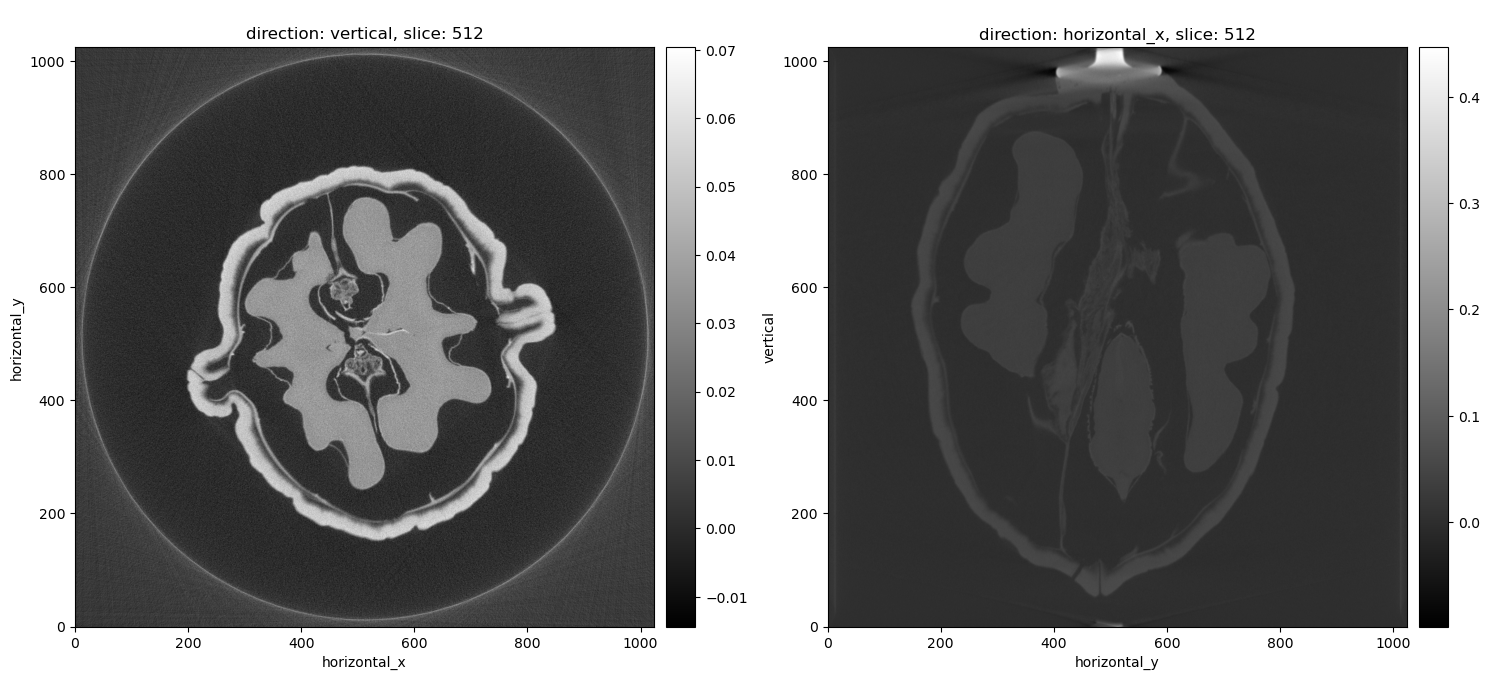

In [19]:
# set up and run the FDK algorithm from CIL with the tigre backend
fdk = FDK(data_broken)
recon = fdk.run(verbose=0)

# visualise the results
show2D(recon, slice_list=[('vertical',centre_slice),('horizontal_x',centre_slice)])

#### Cone angle

Your pixel size needs to be consistent with your source to detector position otherwise your reconstructing with the wrong cone angle. This migth happen if your units are different between your system set up (source and detector position) and your pixel size. The artefacts will get worse towards the outside of the sample as that's where the difference in cone angle is the greatest.

In [20]:
# create a broken geometry by doubling the pixel size
broken_geometry = geometry_correct.copy()    
broken_geometry.set_panel(panel_size, pixel_size=pixel_sixe*2,origin=panel_origin)

# create our AcquisitionData object with the broken geometry
data_broken = AcquisitionData(data_orig, deep_copy=False, geometry=broken_geometry)

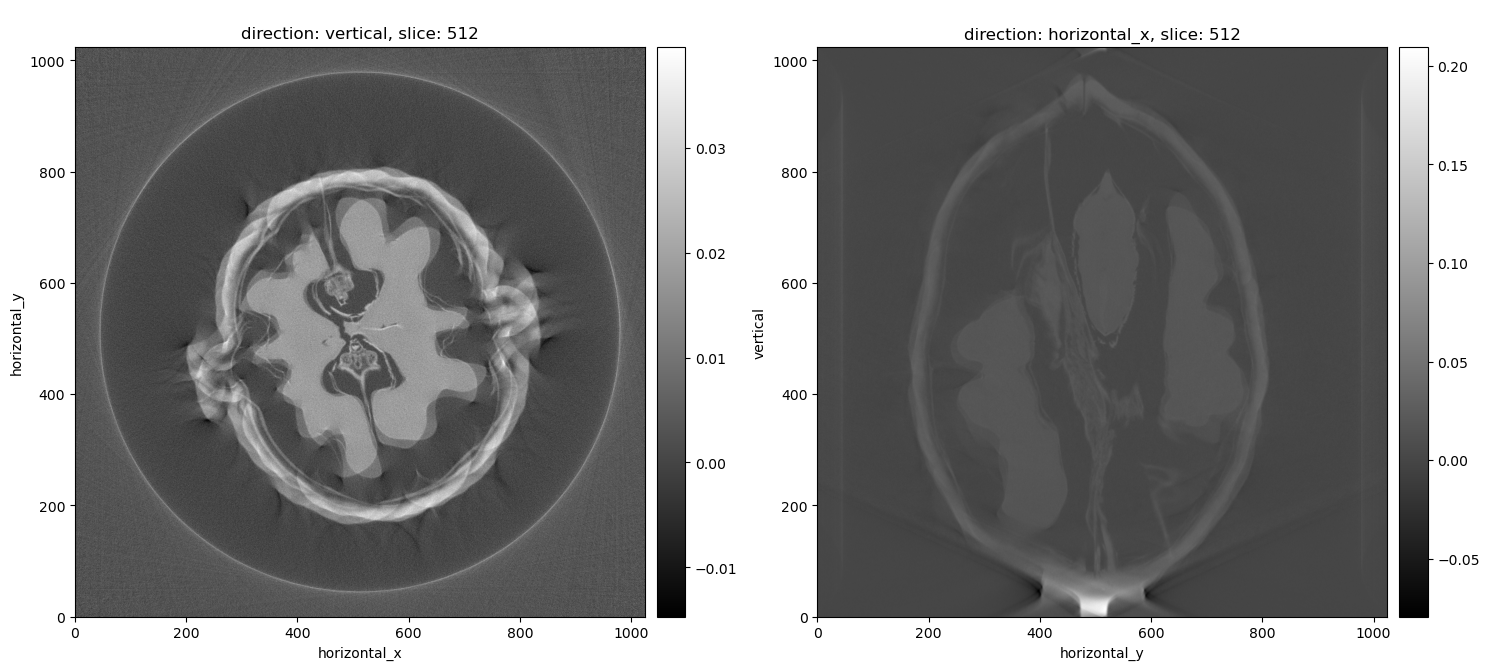

In [21]:
# set up and run the FDK algorithm from CIL with the tigre backend
fdk = FDK(data_broken)
recon = fdk.run(verbose=0)

# visualise the results
show2D(recon, slice_list=[('vertical',centre_slice),('horizontal_x',centre_slice)])